In [ ]:
# ========= 掛載與解壓縮 =========
from google.colab import files
uploaded = files.upload()  # 上傳 dog-breed-identification.zip

Saving dog-breed-identification.zip to dog-breed-identification.zip


In [ ]:
import zipfile, os
zip_path = 'dog-breed-identification.zip'
extract_path = 'dog_data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
# ========= 安裝套件 =========
!pip install seaborn pillow

In [ ]:
# ========= 匯入套件 =========
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
!ls dog_data
!ls dog_data/dog-breed-identification

labels.csv  sample_submission.csv  test  train
ls: cannot access 'dog_data/dog-breed-identification': No such file or directory


In [ ]:
# ========= 資料讀取與處理 =========
base_dir = 'dog_data'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
labels_path = os.path.join(base_dir, 'labels.csv')

df = pd.read_csv(labels_path)
df['filename'] = df['id'] + '.jpg'

✅ 品種總數： 120

📊 前 5 名常見品種：
 breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: count, dtype: int64


<ipython-input-10-f7b429af8d5a>:12: UserWarning: Glyph 21697 (\N{CJK UNIFIED IDEOGRAPH-54C1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-10-f7b429af8d5a>:12: UserWarning: Glyph 31278 (\N{CJK UNIFIED IDEOGRAPH-7A2E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-10-f7b429af8d5a>:12: UserWarning: Glyph 22294 (\N{CJK UNIFIED IDEOGRAPH-5716}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-10-f7b429af8d5a>:12: UserWarning: Glyph 29255 (\N{CJK UNIFIED IDEOGRAPH-7247}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-10-f7b429af8d5a>:12: UserWarning: Glyph 25976 (\N{CJK UNIFIED IDEOGRAPH-6578}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-10-f7b429af8d5a>:12: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-10-f7b429af8d5a>:12: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from

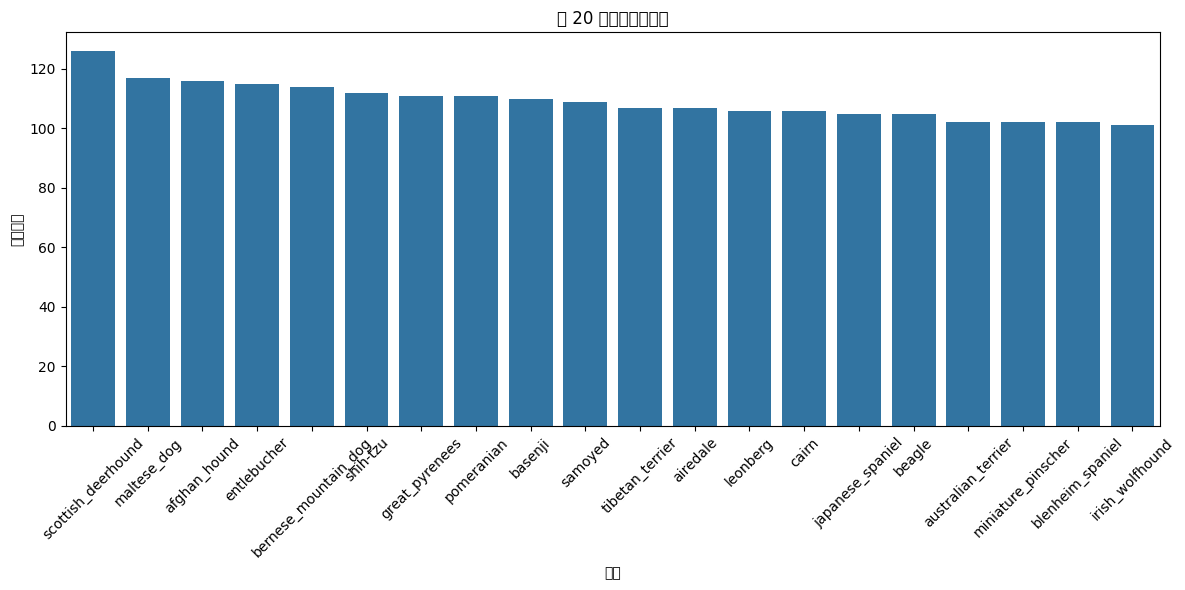

In [ ]:
# ========= 品種統計與視覺化 =========
print("✅ 品種總數：", df['breed'].nunique())
print("\n 前 5 名常見品種：\n", df['breed'].value_counts().head())

plt.figure(figsize=(12, 6))
top_breeds = df['breed'].value_counts()[:20]
sns.barplot(x=top_breeds.index, y=top_breeds.values)
plt.xticks(rotation=45)
plt.title("前 20 名常見的狗品種")
plt.xlabel("品種")
plt.ylabel("圖片數量")
plt.tight_layout()
plt.show()

In [ ]:
# ========= 資料產生器（使用 MobileNetV2 預處理）=========
img_size = 224
batch_size = 32
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_dir,
    x_col='filename',
    y_col='breed',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

valid_generator = datagen.flow_from_dataframe(
    dataframe=df,
    directory=train_dir,
    x_col='filename',
    y_col='breed',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


In [ ]:
# ========= 建立 MobileNetV2 模型 =========
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_tensor=Input(shape=(img_size, img_size, 3))
)
base_model.trainable = False  # 凍結特徵提取層

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(df['breed'].nunique(), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

<ipython-input-12-ad9a213f5bd5>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# ========= 訓練模型 =========
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


256/256 ━━━━━━━━━━━━━━━━━━━━ 396s 2s/step - accuracy: 0.3705 - loss: 2.8852 - val_accuracy: 0.7534 - val_loss: 0.8651
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 380s 1s/step - accuracy: 0.8082 - loss: 0.6524 - val_accuracy: 0.7632 - val_loss: 0.7686
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 399s 2s/step - accuracy: 0.8735 - loss: 0.4388 - val_accuracy: 0.7838 - val_loss: 0.7069
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 399s 2s/step - accuracy: 0.9113 - loss: 0.3168 - val_accuracy: 0.7847 - val_loss: 0.6937
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 387s 2s/step - accuracy: 0.9375 - loss: 0.2410 - val_accuracy: 0.7867 - val_loss: 0.6991
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 392s 2s/step - accuracy: 0.9523 - loss: 0.1978 - val_accuracy: 0.7882 - val_loss: 0.6943
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 395s 2s/step - accuracy: 0.9589 - loss: 0.1678 - val_accuracy: 0.7955 - val_loss: 0.6738
Epoch 8/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 391s 2s/step - accuracy: 0.9736 - loss: 0.1326 - val_accuracy: 0.788

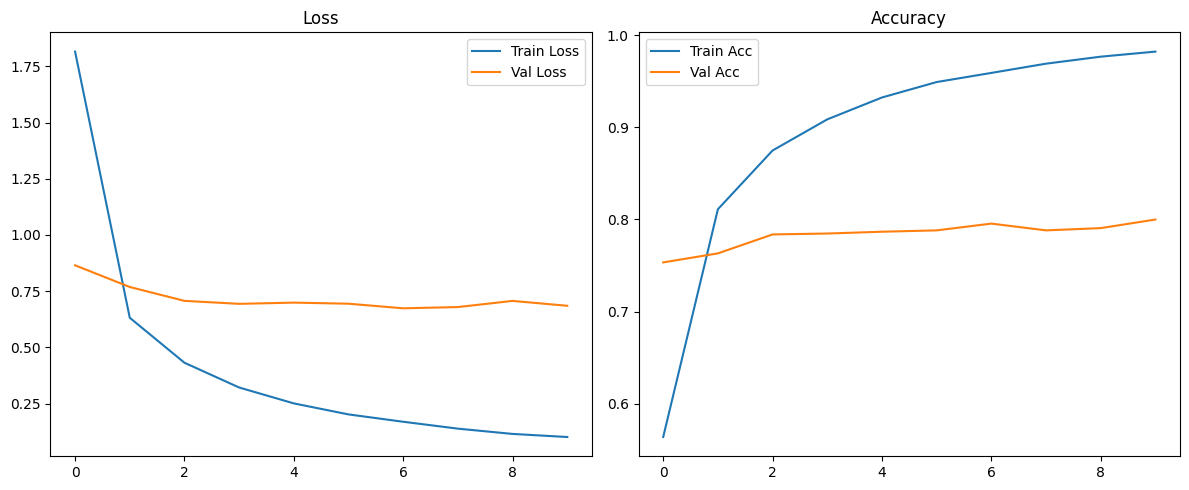

In [ ]:
# ========= 畫圖 =========
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

In [ ]:
# 預測驗證集
Y_pred = model.predict(valid_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = valid_generator.classes
class_names = list(valid_generator.class_indices.keys())

64/64 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step


In [ ]:
# 分類報告
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

📋 Classification Report:
                                precision    recall  f1-score   support

                 affenpinscher       0.00      0.00      0.00        19
                  afghan_hound       0.00      0.00      0.00        21
           african_hunting_dog       0.00      0.00      0.00        13
                      airedale       0.04      0.04      0.04        23
american_staffordshire_terrier       0.00      0.00      0.00        13
                   appenzeller       0.00      0.00      0.00        18
            australian_terrier       0.00      0.00      0.00        21
                       basenji       0.00      0.00      0.00        26
                        basset       0.00      0.00      0.00        18
                        beagle       0.05      0.06      0.05        17
            bedlington_terrier       0.08      0.07      0.08        27
          bernese_mountain_dog       0.00      0.00      0.00        26
       black-and-tan_coonhound       0

In [ ]:
# 混淆矩陣（只看前20品種）
top_20_classes = df['breed'].value_counts().head(20).index.tolist()
indices = [valid_generator.class_indices[breed] for breed in top_20_classes]
cm = confusion_matrix(y_true, y_pred)
cm_20 = cm[np.ix_(indices, indices)]

<ipython-input-21-ebc65e678cbc>:11: UserWarning: Glyph 28151 (\N{CJK UNIFIED IDEOGRAPH-6DF7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-21-ebc65e678cbc>:11: UserWarning: Glyph 28102 (\N{CJK UNIFIED IDEOGRAPH-6DC6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-21-ebc65e678cbc>:11: UserWarning: Glyph 30697 (\N{CJK UNIFIED IDEOGRAPH-77E9}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-21-ebc65e678cbc>:11: UserWarning: Glyph 38499 (\N{CJK UNIFIED IDEOGRAPH-9663}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-21-ebc65e678cbc>:11: UserWarning: Glyph 39006 (\N{CJK UNIFIED IDEOGRAPH-985E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-21-ebc65e678cbc>:11: UserWarning: Glyph 21029 (\N{CJK UNIFIED IDEOGRAPH-5225}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28151 (\N{CJK U

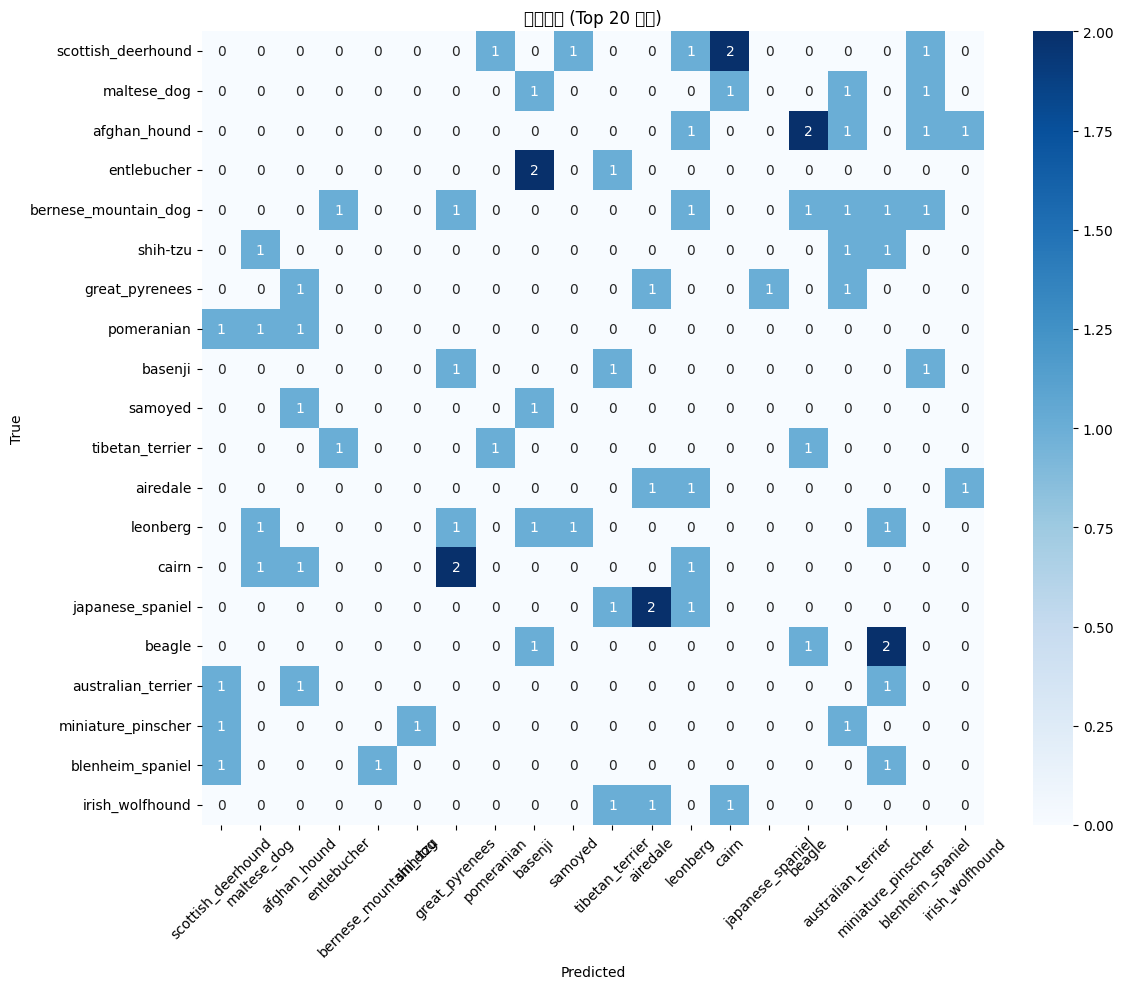

In [ ]:
# 繪製熱力圖
plt.figure(figsize=(12, 10))
sns.heatmap(cm_20, annot=True, fmt='d', cmap='Blues',
            xticklabels=top_20_classes,
            yticklabels=top_20_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('混淆矩陣 (Top 20 類別)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# ========= 預測測試資料集並輸出 submission.csv =========
test_filenames = os.listdir(test_dir)
test_df = pd.DataFrame({'filename': test_filenames})

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=test_dir,
    x_col='filename',
    y_col=None,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

Found 10357 validated image filenames.


In [ ]:
# 預測
preds = model.predict(test_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


323/324 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


324/324 ━━━━━━━━━━━━━━━━━━━━ 392s 1s/step


In [ ]:
# 取得品種標籤順序
breed_labels = train_generator.class_indices
breed_labels = dict((v, k) for k, v in breed_labels.items())
preds_df = pd.DataFrame(preds, columns=[breed_labels[i] for i in range(len(breed_labels))])
preds_df.insert(0, 'id', [fname[:-4] for fname in test_filenames])  # 去掉 .jpg

In [ ]:
# 輸出 CSV
submission_path = 'submission.csv'
preds_df.to_csv(submission_path, index=False)

In [ ]:
# 下載檔案
files.download(submission_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ========= 儲存模型到 .h5 =========
model.save('mobilenetv2_dogbreed.h5')  # 儲存為 .h5

# ========= 下載 .h5 模型檔 =========
files.download('mobilenetv2_dogbreed.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>